<a href="https://colab.research.google.com/github/asheta66/Machine-Learning-2024/blob/main/Classification/GA_FFNN_Ver2_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# -*- coding: utf-8 -*-
"""
GA-ANN Binary Classifier for OSA (NaN-safe, 80/20 split, BCE fitness)
Uses OSA_New_Data.csv (no grouping columns needed).

Outputs:
- cm_train_test.png     (two CMs side-by-side, green, larger font, smaller fig)
- roc_train_test.png    (train + test ROC, smaller fig)
- ga_progress.png       (BCE + MSE convergence per generation)
- wb.json               (W,b,activation per layer for browser HTML)
- best_weights.npy      (flat chromosome)
"""

import json
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)

# -----------------------------
# Configuration
# -----------------------------
RANDOM_SEED      = 23
TEST_SIZE               = 0.20
HIDDEN_SIZE          = 10
POP_SIZE                = 300
GENERATIONS        = 300
ELITE_COUNT         = 10
MUTATION_RATE    = 0.02
MUTATION_STD      = 0.05
WEIGHT_INIT_RANGE = 3.0            # init ~ U[-range, + range]
WEIGHT_CLIP        = 2.0                   # clip AFTER mutation
THRESHOLD          = 0.5
INPUT_CSV            = "OSA_New_Data.csv"   # <<-- your new CSV

np.random.seed(RANDOM_SEED)
# -----------------------------
# Utilities
# -----------------------------
def sigmoid(z: np.ndarray) -> np.ndarray:
    z = np.clip(z, -50, 50)
    return 1.0 / (1.0 + np.exp(-z))

def binary_cross_entropy(y_true: np.ndarray, y_prob: np.ndarray, eps: float = 1e-12) -> float:
    y_true = y_true.reshape(-1, 1)
    y_prob = np.clip(y_prob, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))

def mean_squared_error_prob(y_true: np.ndarray, y_prob: np.ndarray) -> float:
    y_true = y_true.reshape(-1, 1)
    return float(np.mean((y_true - y_prob) ** 2))

def to_binary(series: pd.Series) -> np.ndarray:
    """Convert OSA labels to {0,1}. Accepts numeric or string (yes/no, etc.)."""
    s = series.copy()
    # Try numeric first
    if pd.api.types.is_numeric_dtype(s):
        # Ensure values are 0/1
        vals = s.dropna().unique()
        if set(vals).issubset({0, 1}):
            return s.astype(int).values
        # If e.g. {1,2}, map min->0, max->1
        if len(vals) == 2:
            lo, hi = np.sort(vals)[:2]
            return s.replace({lo: 0, hi: 1}).astype(int).values
    # Fallback: string mapping
    def _map(v):
        if pd.isna(v):
            return np.nan
        t = str(v).strip().lower()
        if t in {"1","yes","y","true","pos","positive","osa"}:
            return 1
        if t in {"0","no","n","false","neg","negative","non-osa","non osa"}:
            return 0
        # Unknown: try numeric cast
        try:
            f = float(t)
            return 1 if f >= 0.5 else 0
        except:
            return np.nan
    return pd.Series([_map(v) for v in s]).astype("float").values

def plot_confusions(cm_train, cm_test, labels=("0","1"), out="cm_train_test.png"):
    fig, axes = plt.subplots(1, 2, figsize=(6.5, 3.2))  # smaller fig
    for ax, cm, title in zip(axes, (cm_train, cm_test), ("Train", "Test")):
        im = ax.imshow(cm, cmap="Greens")
        ax.set_title(f"{title} Confusion Matrix", fontsize=10)
        ax.set_xlabel("Predicted", fontsize=9)
        ax.set_ylabel("Actual", fontsize=9)
        ax.set_xticks([0,1]); ax.set_yticks([0,1])
        ax.set_xticklabels(labels); ax.set_yticklabels(labels)
        # annotate with larger numbers
        for i in range(2):
            for j in range(2):
                ax.text(j, i, str(cm[i, j]), ha="center", va="center", fontsize=12, weight="bold")
    fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
    fig.tight_layout()
    fig.savefig(out, dpi=200, bbox_inches="tight")
    plt.close(fig)

def plot_roc(y_true_train, y_prob_train, y_true_test, y_prob_test, out="roc_train_test.png"):
    fpr_tr, tpr_tr, _ = roc_curve(y_true_train, y_prob_train)
    fpr_te, tpr_te, _ = roc_curve(y_true_test,  y_prob_test)
    auc_tr = auc(fpr_tr, tpr_tr)
    auc_te = auc(fpr_te, tpr_te)

    fig = plt.figure(figsize=(6.0, 3.2))  # smaller fig
    plt.plot([0,1], [0,1], linestyle="--")
    plt.plot(fpr_tr, tpr_tr, label=f"Train AUC={auc_tr:.3f}")
    plt.plot(fpr_te, tpr_te, label=f"Test AUC={auc_te:.3f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.close(fig)

def plot_ga_progress(best_bce, avg_bce, best_mse, avg_mse, out="ga_progress.png"):
    gens = np.arange(1, len(best_bce)+1)
    fig = plt.figure(figsize=(6.5, 3.2))  # smaller fig
    ax1 = plt.gca()
    l1, = ax1.plot(gens, best_bce, label="Best BCE")
    l2, = ax1.plot(gens, avg_bce, label="Avg BCE")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Binary Cross-Entropy")
    ax1.set_title("GA Convergence (BCE & MSE)")

    ax2 = ax1.twinx()
    l3, = ax2.plot(gens, best_mse, linestyle=":", label="Best MSE")
    l4, = ax2.plot(gens, avg_mse, linestyle=":", label="Avg MSE")
    ax2.set_ylabel("Mean Squared Error")

    # merged legend
    lines = [l1, l2, l3, l4]
    labels = [ln.get_label() for ln in lines]
    plt.legend(lines, labels, loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.close(fig)

# -----------------------------
# Load & preprocess
# -----------------------------
df = pd.read_csv(INPUT_CSV)

if "OSA" not in df.columns:
    raise ValueError("Target column 'OSA' not found in the CSV.")

# Drop rows with missing OSA and convert to 0/1
df = df.dropna(subset=["OSA"])
y = to_binary(df["OSA"])
mask_valid = ~np.isnan(y)
df = df.loc[mask_valid].reset_index(drop=True)
y = y[mask_valid].astype(int)

# Use all other **numeric** columns as predictors
X_df = df.drop(columns=["OSA"])
num_cols = [c for c in X_df.columns if pd.api.types.is_numeric_dtype(X_df[c])]
if not num_cols:
    raise ValueError("No numeric predictor columns found in the CSV aside from 'OSA'.")

X = X_df[num_cols].values.astype(float)

# Impute + scale (X only)
imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_imp)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

# -----------------------------
# NN & GA encoding
# -----------------------------
INPUT_SIZE   = X_train.shape[1]
HIDDEN_SIZE  = int(HIDDEN_SIZE)
OUTPUT_SIZE  = 1
WEIGHT_SIZE  = (INPUT_SIZE * HIDDEN_SIZE) + HIDDEN_SIZE + (HIDDEN_SIZE * OUTPUT_SIZE) + OUTPUT_SIZE

def unflatten_weights(w: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    idx = 0
    W1 = w[idx: idx + INPUT_SIZE * HIDDEN_SIZE].reshape((INPUT_SIZE, HIDDEN_SIZE)); idx += INPUT_SIZE * HIDDEN_SIZE
    b1 = w[idx: idx + HIDDEN_SIZE].reshape((1, HIDDEN_SIZE));                                  idx += HIDDEN_SIZE
    W2 = w[idx: idx + HIDDEN_SIZE * OUTPUT_SIZE].reshape((HIDDEN_SIZE, OUTPUT_SIZE));          idx += HIDDEN_SIZE * OUTPUT_SIZE
    b2 = w[idx:].reshape((1, OUTPUT_SIZE))
    return W1, b1, W2, b2

def forward_pass(Xb: np.ndarray, wvec: np.ndarray) -> np.ndarray:
    Xb = np.nan_to_num(Xb, nan=0.0, posinf=0.0, neginf=0.0)
    W1, b1, W2, b2 = unflatten_weights(wvec)
    h = np.tanh(Xb @ W1 + b1)           # tanh hidden
    logits = h @ W2 + b2
    probs = sigmoid(logits)             # sigmoid output
    return np.nan_to_num(probs, nan=0.5, posinf=1.0, neginf=0.0)

# -----------------------------
# GA operators
# -----------------------------
def init_population(pop_size: int, dim: int) -> np.ndarray:
    return np.random.uniform(-WEIGHT_INIT_RANGE, WEIGHT_INIT_RANGE, size=(pop_size, dim))

def evaluate_population(pop: np.ndarray, Xb: np.ndarray, yb: np.ndarray):
    bces = np.empty(pop.shape[0], dtype=float)
    mses = np.empty(pop.shape[0], dtype=float)
    yb = yb.reshape(-1, 1)
    for i, ind in enumerate(pop):
        y_prob = forward_pass(Xb, ind)
        bces[i] = binary_cross_entropy(yb, y_prob)
        mses[i] = mean_squared_error_prob(yb, y_prob)
    return bces, mses

def select_elites(pop: np.ndarray, fitness_bce: np.ndarray, elite_count: int) -> np.ndarray:
    idx = np.argsort(fitness_bce)[:elite_count]
    return pop[idx].copy()

def crossover(parent1: np.ndarray, parent2: np.ndarray) -> np.ndarray:
    point = np.random.randint(1, parent1.size)
    return np.concatenate([parent1[:point], parent2[point:]])

def mutate(w: np.ndarray, rate: float, std: float) -> np.ndarray:
    mask = np.random.rand(w.size) < rate
    w[mask] += np.random.normal(0.0, std, size=np.sum(mask))
    np.clip(w, -WEIGHT_CLIP, WEIGHT_CLIP, out=w)
    return w

# -----------------------------
# GA main loop (+ MSE tracking)
# -----------------------------
population = init_population(POP_SIZE, WEIGHT_SIZE)

best_bce_hist, avg_bce_hist = [], []
best_mse_hist, avg_mse_hist = [], []

for gen in range(GENERATIONS):
    bces, mses = evaluate_population(population, X_train, y_train)
    best_bce_hist.append(float(np.min(bces)))
    avg_bce_hist.append(float(np.mean(bces)))
    best_mse_hist.append(float(np.min(mses)))
    avg_mse_hist.append(float(np.mean(mses)))

    elites = select_elites(population, bces, ELITE_COUNT)

    new_pop = [elites[i % ELITE_COUNT].copy() for i in range(ELITE_COUNT)]
    while len(new_pop) < POP_SIZE:
        p1, p2 = np.random.choice(ELITE_COUNT, 2, replace=False)
        child = crossover(elites[p1], elites[p2])
        child = mutate(child, rate=MUTATION_RATE, std=MUTATION_STD)
        new_pop.append(child)
    population = np.vstack(new_pop)

# Best individual after evolution (by BCE on TRAIN)
final_bces, final_mses = evaluate_population(population, X_train, y_train)
best_idx = int(np.argmin(final_bces))
best_weights = population[best_idx].copy()

# -----------------------------
# Evaluate
# -----------------------------
y_train_prob = forward_pass(X_train, best_weights).ravel()
y_test_prob  = forward_pass(X_test,  best_weights).ravel()

y_train_prob = np.clip(np.nan_to_num(y_train_prob, nan=0.5, posinf=1.0, neginf=0.0), 1e-8, 1 - 1e-8)
y_test_prob  = np.clip(np.nan_to_num(y_test_prob,  nan=0.5, posinf=1.0, neginf=0.0),  1e-8, 1 - 1e-8)

y_train_pred = (y_train_prob >= THRESHOLD).astype(int)
y_test_pred  = (y_test_prob  >= THRESHOLD).astype(int)

def get_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    return {
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred, zero_division=0),
        "F1":        f1_score(y_true, y_pred, zero_division=0),
    }

train_metrics = get_metrics(y_train, y_train_pred)
test_metrics  = get_metrics(y_test,  y_test_pred)

metrics_df = pd.DataFrame([train_metrics, test_metrics], index=["Train", "Test"]).T
print("\n=== Classification Metrics ===")
# metrics_df.round(4)

# -----------------------------
# Export weights for browser
# -----------------------------
# Unflatten best_weights into layer tensors and save as wb.json
def export_wb_json(wvec, path="wb.json"):
    W1, b1, W2, b2 = unflatten_weights(wvec)
    layers = [
        {"W": W1.tolist(), "b": b1.ravel().tolist(), "activation": "tanh"},
        {"W": W2.tolist(), "b": b2.ravel().tolist(), "activation": "sigmoid"},
    ]
    with open(path, "w") as f:
        json.dump(layers, f, indent=2)

np.save("best_weights.npy", best_weights)
export_wb_json(best_weights, "wb.json")
print("\nSaved: cm_train_test.png, roc_train_test.png, ga_progress.png, best_weights.npy, wb.json")


=== Classification Metrics ===

Saved: cm_train_test.png, roc_train_test.png, ga_progress.png, best_weights.npy, wb.json


In [26]:
metrics_df.round(4).T

,Accuracy,Precision,Recall,F1
Train,0.9588,0.9929,0.9336,0.9624
Test,0.9400,1.0000,0.8938,0.9439


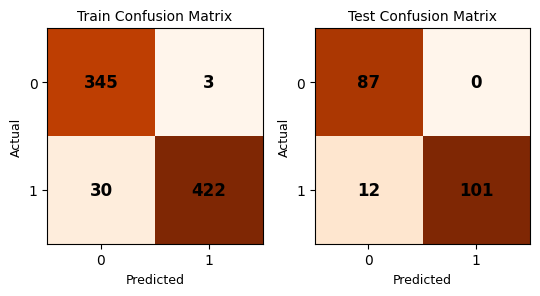

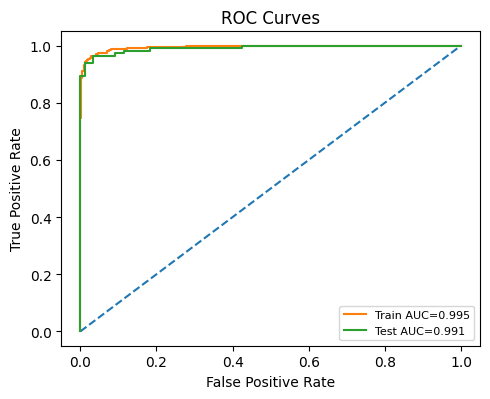

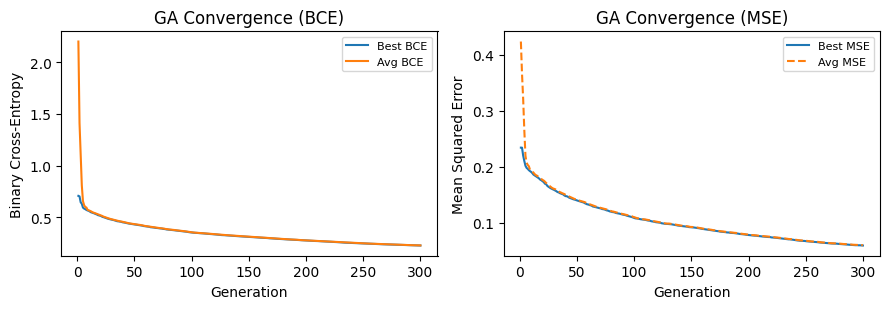

In [27]:
def plot_confusions(cm_train, cm_test, labels=("0","1")):
    """Show and save side-by-side confusion matrices (no colorbar)."""
    fig, axes = plt.subplots(1, 2, figsize=(5.5, 3.2))  # smaller fig

    for ax, cm, title in zip(axes, (cm_train, cm_test), ("Train", "Test")):
        im = ax.imshow(cm, cmap="Oranges")
        ax.set_title(f"{title} Confusion Matrix", fontsize=10)
        ax.set_xlabel("Predicted", fontsize=9)
        ax.set_ylabel("Actual", fontsize=9)
        ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
        ax.set_xticklabels(labels); ax.set_yticklabels(labels)
        for i in range(2):
            for j in range(2):
                ax.text(j, i, str(cm[i, j]), ha="center", va="center",
                        fontsize=12, weight="bold")

    fig.tight_layout()
    fig.savefig("cm_train_test.png", dpi=200, bbox_inches="tight")
    plt.show()



def plot_roc(y_true_train, y_prob_train, y_true_test, y_prob_test):
    """Show and save ROC curves for train and test."""
    fpr_tr, tpr_tr, _ = roc_curve(y_true_train, y_prob_train)
    fpr_te, tpr_te, _ = roc_curve(y_true_test,  y_prob_test)
    auc_tr = auc(fpr_tr, tpr_tr)
    auc_te = auc(fpr_te, tpr_te)

    fig = plt.figure(figsize=(5.0, 4.1))  # smaller fig
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.plot(fpr_tr, tpr_tr, label=f"Train AUC={auc_tr:.3f}")
    plt.plot(fpr_te, tpr_te, label=f"Test AUC={auc_te:.3f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    plt.savefig("roc_train_test.png", dpi=200, bbox_inches="tight")
    plt.show()
    # plt.close(fig)


def plot_ga_progress(best_bce, avg_bce, best_mse, avg_mse):
    """Show and save GA convergence with two subplots: BCE and MSE."""
    gens = np.arange(1, len(best_bce) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3.2))  # two side-by-side subplots

    # ---- BCE subplot ----
    ax1.plot(gens, best_bce, label="Best BCE")
    ax1.plot(gens, avg_bce, label="Avg BCE")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Binary Cross-Entropy")
    ax1.set_title("GA Convergence (BCE)")
    ax1.legend(fontsize=8)

    # ---- MSE subplot ----
    ax2.plot(gens, best_mse, linestyle="-", label="Best MSE")
    ax2.plot(gens, avg_mse, linestyle="--", label="Avg MSE")
    ax2.set_xlabel("Generation")
    ax2.set_ylabel("Mean Squared Error")
    ax2.set_title("GA Convergence (MSE)")
    ax2.legend(fontsize=8)

    fig.tight_layout()
    fig.savefig("ga_progress.png", dpi=200, bbox_inches="tight")
    plt.show()
    # plt.close(fig)

# --- Confusion matrices ---
cm_tr = confusion_matrix(y_train, y_train_pred)
cm_te = confusion_matrix(y_test,  y_test_pred)
plot_confusions(cm_tr, cm_te, labels=("0", "1"))

# --- ROC curves ---
plot_roc(y_train, y_train_prob, y_test, y_test_prob)

# --- GA progress ---
plot_ga_progress(best_bce_hist, avg_bce_hist, best_mse_hist, avg_mse_hist)
